In [35]:
base_dir = '/content/drive/MyDrive/ml4proj'

In [36]:
import os
import re
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.signal

In [37]:
erp_df =  pd.read_csv(base_dir + '/archive/ERPdata.csv')

erp_df.head()

,subject,condition,Fz,FCz,Cz,FC3,FC4,C3,C4,CP3,CP4,time_ms
0,1,1,5.533701,5.726507,5.469535,5.386723,4.588875,6.560092,4.542811,5.397492,5.103695,-1500.0000
1,1,1,5.651489,5.837326,5.773131,5.627975,4.822217,6.739976,4.811770,5.541357,5.379273,-1499.0234
2,1,1,5.717580,5.932924,5.948466,5.826460,4.979647,7.026199,5.053779,5.634972,5.600504,-1498.0469
3,1,1,5.703267,5.968103,5.851512,5.812192,4.992899,6.940671,5.106650,5.543577,5.589775,-1497.0703
4,1,1,5.571578,5.917541,5.812808,5.744715,4.963338,6.726491,5.158073,5.454069,5.614092,-1496.0938


# Some things about dataset

In [38]:
demographic_df = pd.read_csv(base_dir + '/archive/demographic.csv')

demographic_df = demographic_df.rename(columns=lambda x: x.strip())
demographic_df['group'] = demographic_df['group'].astype(int)

## Subject count


In [39]:
demographic_df['subject'].count()


81

## Target class distribution

1    49
0    32
Name: group, dtype: int64


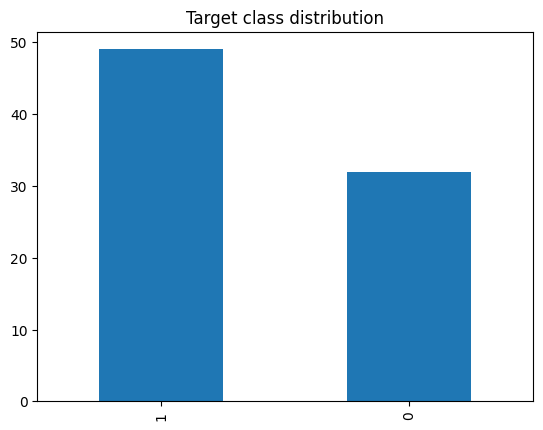

In [40]:
demographic_df['group'].value_counts().plot(kind='bar')
plt.title('Target class distribution')
print(demographic_df['group'].value_counts())

## Example plot

<Axes: xlabel='sample'>

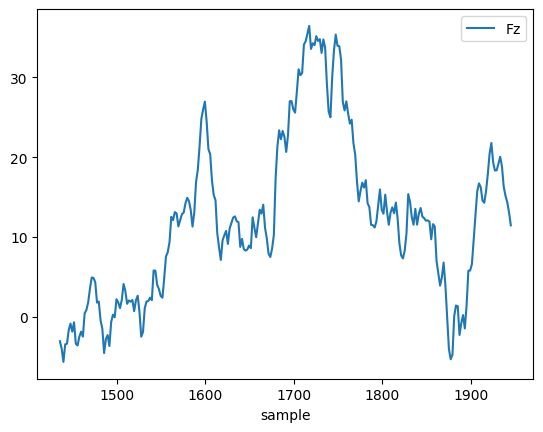

In [41]:
example =  pd.read_csv(base_dir + '/stripped/1.csv')

example[example['trial'] == 10.0].plot(x='sample', y='Fz')

In [59]:
example.head(5)

,trial,sample,Fz,FCz,Cz,CPz,Pz
0,10.0,1435.5,-3.04880,-5.89500,-5.00005,-7.99040,-7.96630
1,10.0,1437.5,-3.97110,-6.08425,-5.56280,-7.60650,-7.71725
2,10.0,1439.5,-5.64050,-7.32660,-6.60620,-6.40970,-7.42880
3,10.0,1441.5,-3.43885,-6.47980,-6.12495,-6.70395,-7.56060
4,10.0,1443.5,-3.36590,-6.70885,-7.63000,-8.82770,-10.66350


## Classification using RandomForest

The Kaggle dataset includes `ERPdata.csv`. It's already processed file, however, as authors said it can be used to `replicate prior thesis` so it's useful but doesn't contain all the data to replicate the article we are working on.

What we are doing in this section is:
- visualization of n100, p200 windows
- extracting features for RandomForest (it cannot work with timeseries):
  - n100 min amplitude, p200 max amplitude
  - mean ampltitude during n100 time window
  - mean amplitude during p200 time window
  - above is done for each electrode separately, now we have 18 features after doing all the work written above
- fitting RandomForestClassifer using RFECV (feature selection) and StratifiedKFold  

What we are missing: more features (we would need to include more electrodes and calculate also slopes of EEG func)


In [42]:
df = erp_df.merge(demographic_df, left_on='subject', right_on='subject')

df = df.rename(columns=lambda x: x.strip())

In [43]:
df.info()

# used in the paper or proposed idk but use Ctrl-F to find context in a paper: Fz, FCz, Cz, CPz, and Pz
electrodes = ['Fz','FCz','Cz','FC3','FC4','C3','C4','CP3','CP4']
features_electrodes = ['Fz', 'FCz', 'Cz', 'CP4']
n100_window = (75, 120)
p200_window = (150, 250)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 746496 entries, 0 to 746495
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   subject    746496 non-null  int64  
 1   condition  746496 non-null  int64  
 2   Fz         746496 non-null  float64
 3   FCz        746496 non-null  float64
 4   Cz         746496 non-null  float64
 5   FC3        746496 non-null  float64
 6   FC4        746496 non-null  float64
 7   C3         746496 non-null  float64
 8   C4         746496 non-null  float64
 9   CP3        746496 non-null  float64
 10  CP4        746496 non-null  float64
 11  time_ms    746496 non-null  float64
 12  group      746496 non-null  int64  
 13  gender     746496 non-null  object 
 14  age        746496 non-null  int64  
 15  education  746496 non-null  float64
dtypes: float64(11), int64(4), object(1)
memory usage: 96.8+ MB


In [44]:
# from collections import defaultdict

# averaged_peaks = defaultdict(lambda: defaultdict(int))

# def get_offset(subject_data, relative_index):
#     return subject_data.index[0] + relative_index

# def find_trial_global_peaks(trial_array, electrode):
#     signal_data = trial_array

#     peaks, _ = scipy.signal.find_peaks(signal_data)
#     max_positive = peaks[np.argmax(signal_data[peaks])]

#     # inverse signal so we get index of the bottom peak
#     peaks, _ = scipy.signal.find_peaks(-signal_data)
#     max_negative = peaks[np.argmin(signal_data[peaks])]

#     return max_positive, max_negative


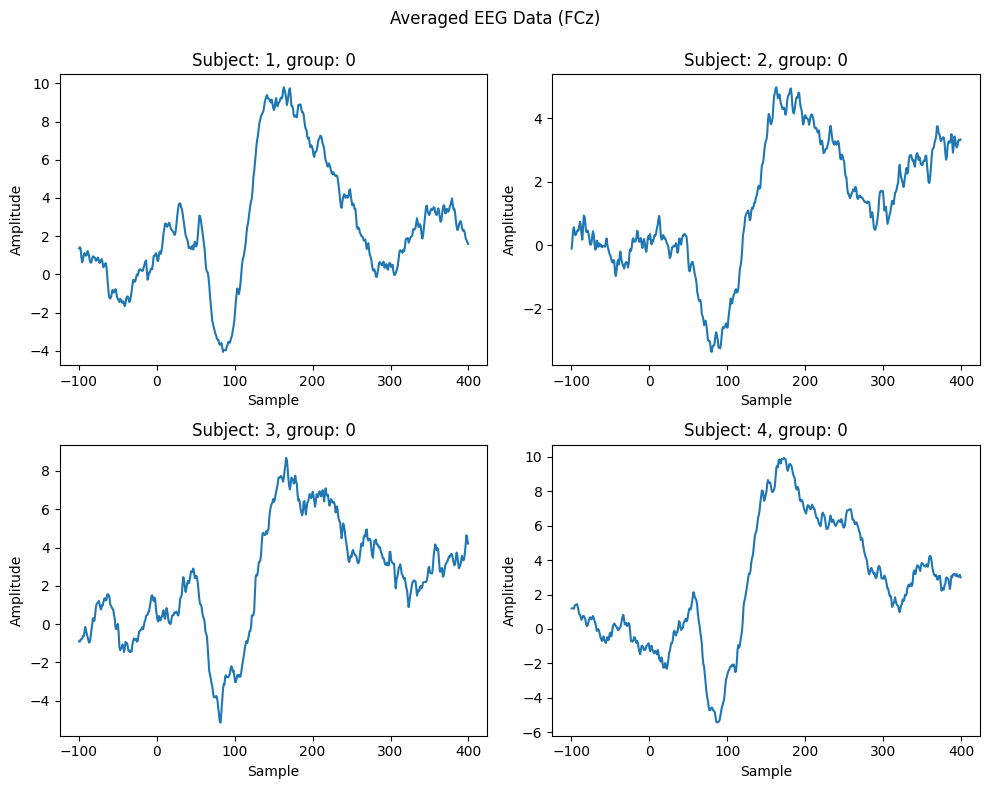

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(f'Averaged EEG Data (FCz)')

subjects = list(df['subject'].unique()[:4])
for ax in axs.flat:
  subject = subjects[0]
  subjects = subjects[1:]

  subject_data = df[df['subject'] == subject]
  subject_data = subject_data[subject_data['condition'] == 1]
  subject_data = subject_data[(subject_data['time_ms'] >= -100) & (subject_data['time_ms'] < 400)]

  ax.plot(subject_data['time_ms'], subject_data['FCz'])

  ax.set_title(f'Subject: {subject}, group: {subject_data["group"].values[0]}')
  ax.set_xlabel('Sample')
  ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()


In [46]:
df = df.groupby(['subject', 'time_ms', 'group'], as_index=False)[electrodes].mean()

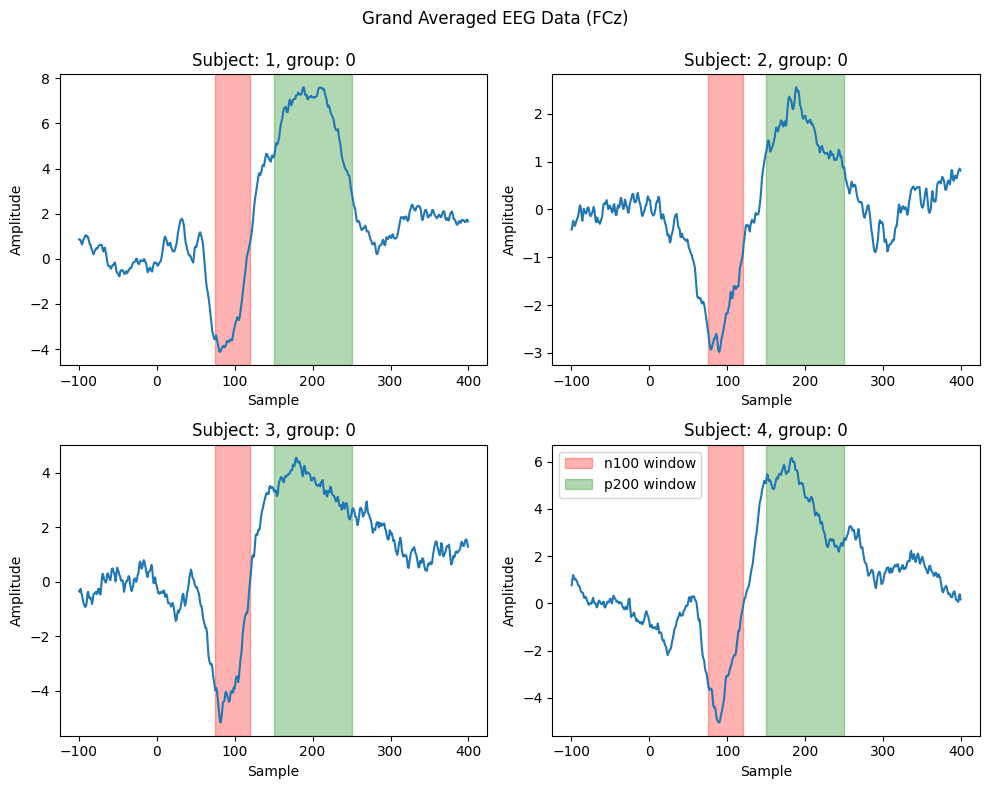

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(f'Grand Averaged EEG Data (FCz)')

subjects = list(df['subject'].unique()[:4])
for ax in axs.flat:
  subject = subjects.pop(0)

  subject_data = df[df['subject'] == subject]
  subject_data = subject_data[(subject_data['time_ms'] >= -100) & (subject_data['time_ms'] < 400)]

  ax.plot(subject_data['time_ms'], subject_data['FCz'])

  ax.set_title(f'Subject: {subject}, group: {subject_data["group"].values[0]}')
  ax.set_xlabel('Sample')
  ax.set_ylabel('Amplitude')

  ax.axvspan(n100_window[0], n100_window[1], color='red', alpha=0.3, label='n100 window')

  ax.axvspan(p200_window[0], p200_window[1], color='green', alpha=0.3, label='p200 window')



plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()


In [52]:
n100_electrodes = p200_electrodes = features_electrodes

def extract_n100_p200_at_channels(df):
  n100_time_window = df[(df['time_ms'] >= n100_window[0]) & (df['time_ms'] <= n100_window[1])]
  n100_data = n100_time_window[n100_electrodes]

  p200_time_window = df[(df['time_ms'] >= p200_window[0]) & (df['time_ms'] <= p200_window[1])]
  p200_data = p200_time_window[p200_electrodes]

  # we pick min/max separately for each electrode
  n100_min_amplitude = n100_data.min()
  p200_max_amplitude = p200_data.max()

  n100_mean = n100_data.mean()
  p200_mean = p200_data.mean()

  # order is important
  return [*n100_min_amplitude, *p200_max_amplitude, *n100_mean, *p200_mean]

In [53]:
new_columns = []
new_columns_names = ['subject', 'group']

for feature in features_electrodes:
  new_columns_names.append(f'{feature}_min')

for feature in features_electrodes:
  new_columns_names.append(f'{feature}_max')

for feature in features_electrodes:
  new_columns_names.append(f'{feature}_n100_mean')

for feature in features_electrodes:
  new_columns_names.append(f'{feature}_p200_mean')

subjects = df['subject'].unique()

In [54]:
for subject in subjects:
  chunk = df[df['subject'] == subject]
  group = chunk['group'].unique()[0]
  new_columns.append([subject, group] + extract_n100_p200_at_channels(chunk))


finished = pd.DataFrame(new_columns, columns=new_columns_names)

In [57]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler

X = finished[new_columns_names[2:]]
y = finished['group'].astype(int)

scaler = StandardScaler()

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
rf = RandomForestClassifier(n_estimators = 100, random_state=42)

skf = StratifiedKFold(n_splits=5)

rfecv = RFECV(estimator=rf, step=1, min_features_to_select=10, cv=skf)
rfecv.fit(X_train, y_train)

rf.fit(X_train[:, rfecv.support_], y_train)

y_pred = rf.predict(X_test[:, rfecv.support_])
y_prob = rf.predict_proba(X_test[:, rfecv.support_])[:, 1]

report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.82      0.82      0.82        11

    accuracy                           0.76        17
   macro avg       0.74      0.74      0.74        17
weighted avg       0.76      0.76      0.76        17



## Summary


In the previous section, we accomplished the following:
- **Visualization of N100 and P200 windows.**
- **Calculation of 'grand averages':** Averaging time series from three conditions for each subject, reducing it to a single time series per subject.
- **Feature Extraction for RandomForest:**
  - Minimum amplitude during the N100 window and maximum amplitude during the P200 window.
  - Mean amplitude during the N100 and P200 time windows.
  - Performed separately for each electrode, resulting in 18 distinct features.
- **Fitted a RandomForestClassifier:** Employing RFECV for feature selection and StratifiedKFold for cross-validation.

## Areas for Improvement

- **More Features Needed:** To improve the model, we need to include additional electrodes and calculate the slopes of EEG functions.
- Deep Learning model

## Current Status

- We have a foundational model, which now allows for experimentation with hyperparameters and the addition of extra features.

## Challenges in Working with Raw Data

- The primary issue is working with raw data. The dataset `ERPdata.csv` is well-prepared, but lacks comprehensive electrode coverage. The time series spans from 1500ms before to 1500ms after the stimulus, as indicated by the `time_ms` column.
- **Uncertainty in Raw Data Handling:** Time in the raw data is represented by the `sample` number column, starting at `1400`, but it's unclear whether `1400` refers to milliseconds or is simply a sample number. To accurately define windows like P200 or N100, we might need to establish a reference, possibly by identifying the largest amplitude peak and analyzing samples within the (75, 200) interval around this peak.
